In [2]:
# gaussian processes probably 1 dim to start off with

In [3]:
%%capture output
%pip install numpy
%pip install matplotlib
%pip install math

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

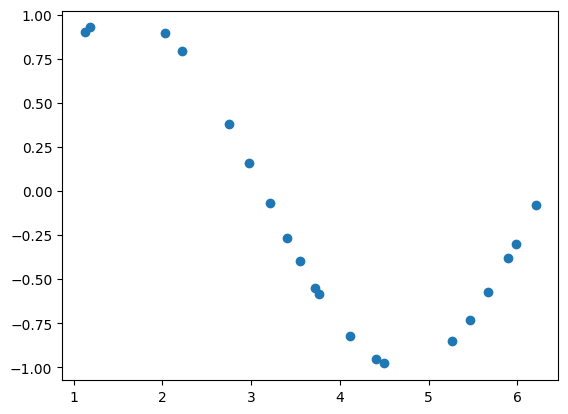

In [5]:
def some_unknown_function(X):
    return np.sin(X)
    return [math.sin(x) for x in X]

def check_dist(X):
    plt.plot(X,some_unknown_function(X),'o')
    return

X = np.random.rand(20)*2*(math.pi)
y = some_unknown_function(X)
check_dist(X)

ok so i need ot work out some mean function m inbetween the bounds (0-2pi) then choose a kernel function or distribution of kernel functions that can be sampled from? use that to make the covar matrix, then i think there is some build in thing that save me reading through 4 pages of equations to get the the solution??? idk

In [10]:
# could i guess make this first funciton private as
# it is only meant to be accessed by the handler

# max corr from this is 1 so s.d vector * gauss_corr
# to get the covar matrix
def gauss_corr(l, a_vec, b_vec):
    # a and b are points they could be scalar or vector
    exponent = 0
    for a,b in zip(a_vec, b_vec):
        exponent += -(1/2*l)*(a-b)**2
        
    return (math.e)**exponent

#this sends of x1x1 x1x2 and so on to the guass_corr calc
# for 1 input x this isn't all that important but higher dims
# will benifit from this expected form [[x1,x2],[x1,x2]]
def gauss_corr_handler(X, l=0.1):
    R = []
    X = np.array(X)
    X_shape = (X.shape)[0]
    R = np.zeros((X_shape,X_shape))
    for i, x_vec_1 in enumerate(X):
        for j, x_vec_2 in enumerate(X):
            R[i][j] = gauss_corr(l,x_vec_1,x_vec_2)
    return R

#form [[x1,x2],[x1,x2]]
# I think the first vector would be referred to as X1
X = [[1,1],[1,1],[2,2]]
X = np.array(X)
print(X.shape)
theta_vec = [1,1]
R = gauss_corr_handler(X)
# this output looks correct which is good
# using identical x vals give a load of
# ones which is the expected behaviour ...
print(R)

# just checking it can also deal with single dims:
X_test = [[1],[0],[6]]
print(gauss_corr_handler(X_test))
# good still works with this as well so functions are ok



(3, 2)
[[1.         1.         0.90483742]
 [1.         1.         0.90483742]
 [0.90483742 0.90483742 1.        ]]
[[1.         0.95122942 0.2865048 ]
 [0.95122942 1.         0.16529889]
 [0.2865048  0.16529889 1.        ]]


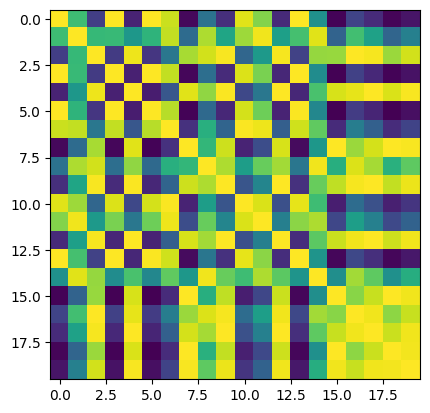

In [7]:

X = np.random.rand(20)*2*(math.pi)
# makes X the correct shape for the handler
# altho if x goes up in dims this is going to cause issues
# should be (-1,) but then my iterator won't work
X = X.reshape(-1,1)
y = some_unknown_function(X)
R = gauss_corr_handler([0.1],X)
plt.imshow(R)

Judging off of the above plot everything is scaling properly into higher dimensions, just need to figure out the rest of the maths

I think i could make predictions for a set of values linearly spaced out froim 0-2pi and use this to make a line of best fit
I'm just not 100% sure how to make prediciotns at the moment

Also is the above literally what the spearman corr coefficient is??? - actually it can't be bc spearman is relating the inputs to one output value right?

I was using this for the two code blocks above btw (https://cran.r-project.org/web/packages/GauPro/vignettes/IntroductionToGPs.html#:~:text=The%20mean%20function%20can%20be,usually%20estimated%20using%20the%20data. ) 

# problem
Its great that i have the correlation between the inputs but how does this relate to the outputs or anything i actually wnat to work out in the target dist?

In [8]:
# ok so now we want to find M which for this case should be 
# n*1 bc our output dimension is one and we have n inputs


# R needs to be multiplited by some s_d vector i'm going to
# just use ones but this is a hyperparam that should be tuned
R = np.array(R)
# ok i don't know if s_d should be a vector that i then square
# to get an n by n var matrix, but then surely that would 
#throw off the correlation matrix and mess stuff up vs just a
# single scalar which makes way more sense in terms of the matrix maths

s_d = 0.01
sigma_matrix = R*s_d
print(R.shape,sigma_matrix.shape)
#uses a 1 by n vector:
one_n = np.ones((sigma_matrix.shape)[0])
# odn't put -1,1 leave second one black otherwise a lot of mat
# maths in numpy doesn't work
one_n_transpose = one_n.reshape(-1,)
sigma_matrix_inv = np.linalg.inv(sigma_matrix)
print(sigma_matrix_inv.shape)
print(one_n_transpose.shape)

# print below showd that the above code is correct
# print(one_n ,one_n_transpose)
y = y.reshape(-1,)
print(y.shape)
# a/b = a*(b**-1)

M_denom = np.matmul(one_n_transpose,sigma_matrix_inv,one_n)
try:
    M_denom_inv = np.linalg.inv(M_denom)
    M_hat = np.matmul(one_n_transpose,sigma_matrix_inv,y,M_denom)
#in this case M_denom is a constant bc one var so its errors
# if i try to inverse it
except:
    M_hat = np.matmul(one_n_transpose,sigma_matrix_inv,y)/M_denom

# the values of M_hat are way too big idk if this is an issue
# with my heyperparameter selection, or whether it is something 
# else like my maths actually being wrong
print(M_hat)


(20, 20) (20, 20)
(20, 20)
(20,)
(20,)
[-4.64279224e+18 -4.16842696e+18 -2.54522703e+19 -3.32125313e+18
 -1.60522353e+18 -1.80988471e+18 -7.40398037e+18  4.27784816e+18
 -3.45042244e+18 -5.16734631e+18 -9.07716976e+18 -5.22479947e+18
 -5.30626223e+17 -5.90506344e+18 -3.50821070e+18  2.42702311e+17
 -7.20458467e+18  5.44694458e+17  7.89917991e+17 -3.64074237e+18]


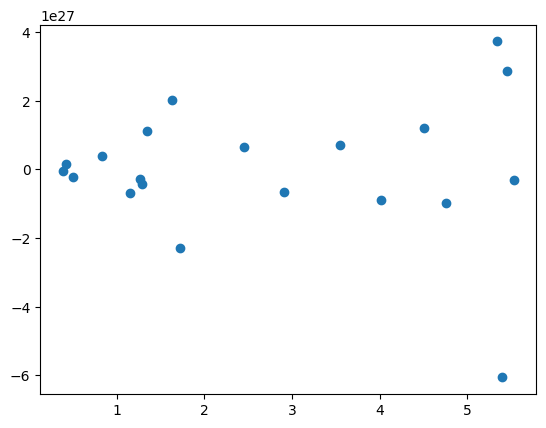

In [9]:
# also getting weird plots on X, y which is fine above
# i guess i have messed up the dimensions
plt.plot(X,y,'o')
